In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, vaccination_dashboard
import requests

In [3]:
release=None

In [4]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-18,2021-01-17,United Kingdom,K02000001,4711,NaN,166.0,417329.0
1,2021-01-18,2021-01-16,United Kingdom,K02000001,23414,NaN,460.0,491137.0
2,2021-01-18,2021-01-15,United Kingdom,K02000001,37510,NaN,643.0,596727.0
3,2021-01-18,2021-01-14,United Kingdom,K02000001,41436,3984.0,939.0,695148.0
4,2021-01-18,2021-01-13,United Kingdom,K02000001,44899,4182.0,977.0,628556.0
...,...,...,...,...,...,...,...,...
349,2021-01-18,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
350,2021-01-18,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
351,2021-01-18,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
352,2021-01-18,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [5]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-18.csv')

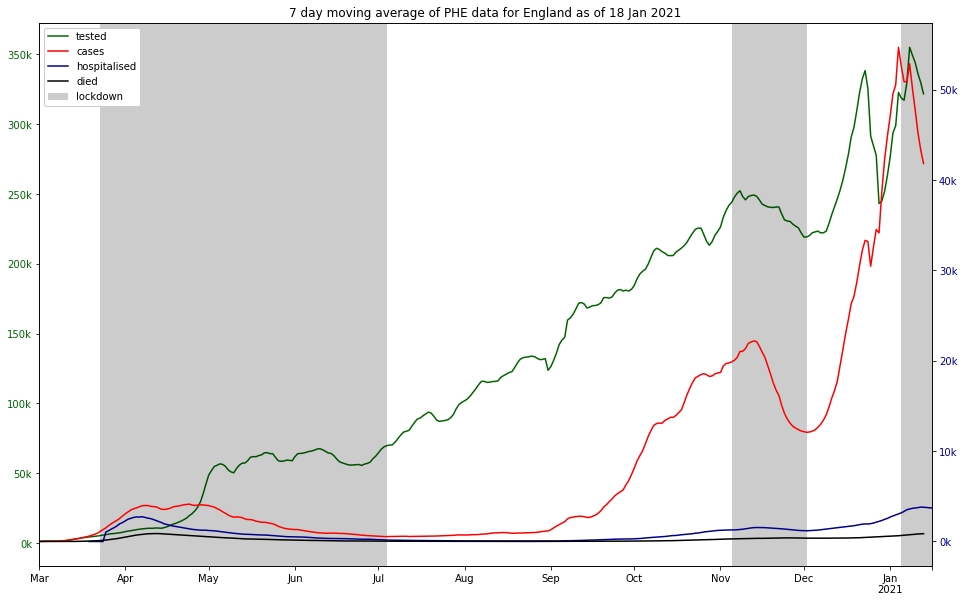

In [6]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [7]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-18.csv')

In [8]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-18.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,21016.0,125717.0,104701.0,1893667,1.109804,5.529008,93.361188
1,Scotland,S92000003,3698.0,264991.0,261293.0,5463300,0.067688,4.782695,95.149617
2,Wales,W92000004,201.0,151737.0,151536.0,3152879,0.006375,4.806274,95.187351
3,England,E92000001,427386.0,3520056.0,3092670.0,56286961,0.759298,5.494470,93.746232


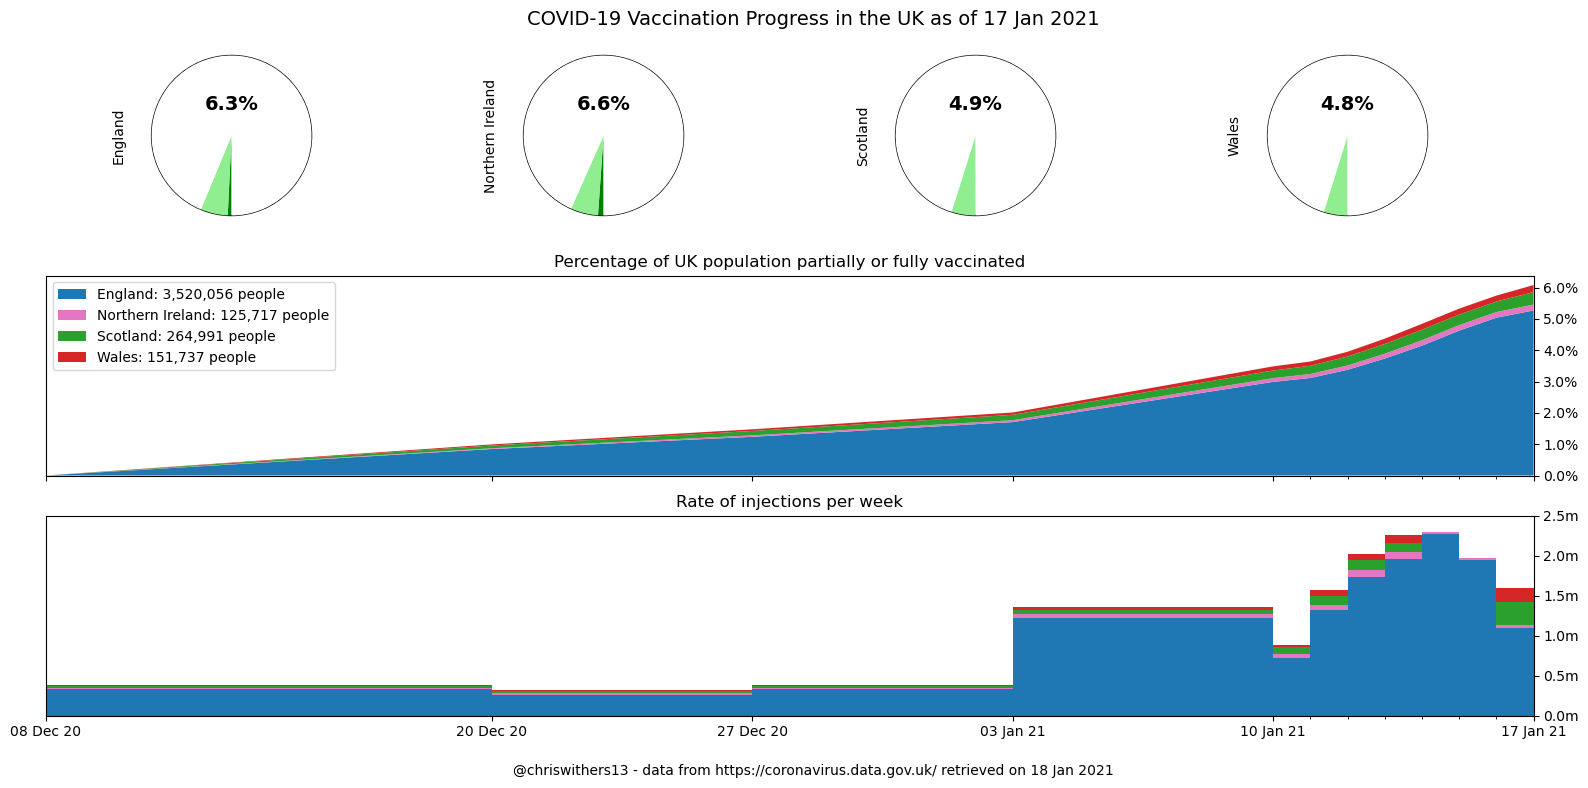

In [9]:
vaccination_dashboard()

In [10]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-18.csv')

In [11]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-18.csv')

In [12]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-18.csv')

In [13]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-18, release: 2021-01-18 16:43:56.611546+00:00, msoa: 2021-01-18 17:03:38+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-18.csv')